Hot days:

 - timeseries of daily maxima over 40 years.
 - Map plot the average (over 40 years) of the annual maximum of the daily maxima
 - Map plot the linear trend (over 40 years) in the annual maxima of the daily maxima
 - Map plot of P97 of the daily maxima.

Duration of hot days:

 - Plot the longest duration (in units of days) where daily maxima > P97 of daily maxima.


Hot Nights:

·      Calculate a timeseries of daily minima over 40 years.
·      Map plot the average (over 40 years) of the annual maximum of the daily minima
·      Map plot the linear trend (over 40 years) in the annual maxima of the daily minima
·      Map plot of P97 of the daily minima.

 
Duration of hot nights:

·      Plot the longest duration (in units of days) where daily minima > P97 of daily minima.


In [1]:
import os.path
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
 
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import datetime

In [2]:
def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
    
def plot_map(da_2d, cnlevel):
    fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
    ax_coastlines_country(axs)
    axs.add_feature(cfeature.STATES, linestyle=':')

    im=da_2d.plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

    # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
    axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
    axs.add_feature(cfeature.STATES, linestyle=':')
 
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
    fig.colorbar(im, cax=cbar_ax,orientation='horizontal'); 
    
# reference https://www.tutorialspoint.com/longest-consecutive-sequence-in-python
def longestConsecutive(arr, t0):
    '''
    arr:1d numpy array
    t0: threshold 
    find the longest sequece of arr>t0
          duration of hot days
    '''
    len_a = len(arr)
    longest = 0
    print(len_a, "aaaaaa")
    for n in range(len_a):
        if arr[n-1] < t0 and arr[n]> t0:   
            current = i
            streak = 0
            while arr[n] > t0:   
               n+=1
               streak+=1
               longest = max(longest,streak)
    return longest   


In [3]:
proj = ccrs.PlateCarree()

#### The average (over 42 years) of the annual maximum of the daily maxima  

In [19]:
dir_i = '/glade/campaign/mmm/c3we/mingge/wetbulb/daily_max/'

In [20]:
year_s = 1979
year_e = 2020
 
n_year = year_e - year_s + 1
n_month = 12

n_lat = 721
n_lon = 1440

flnm_o = dir_i + 'TWB_' + str(year_s) + '-' + str(year_e) + '_annual_max.nc' 

if not os.path.exists(flnm_o): 
    # get daily maximum
    for year in range(year_s, year_e + 1):
        for month in range(1, n_month+1, 1):
            flnm_i = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_dailyMax.nc'
            print(flnm_i)
            with xr.open_dataset(flnm_i) as ds:
                twb = ds['TWB'].max(dim='dayofyear')
            if month == 1:
                twb_0 = twb 
            else:
                twb_3d = xr.concat([twb_0, twb], "month")
                twb_0 = twb_3d
            
        twb_max = twb_3d.max(dim='month') 
        if year == year_s:
            twb_1 = twb_max
        else:
            twb_3d = xr.concat([twb_1, twb_max], "year")
            twb_1 = twb_3d
     
    twb_3d.to_netcdf(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        twb_3d = ds['TWB']


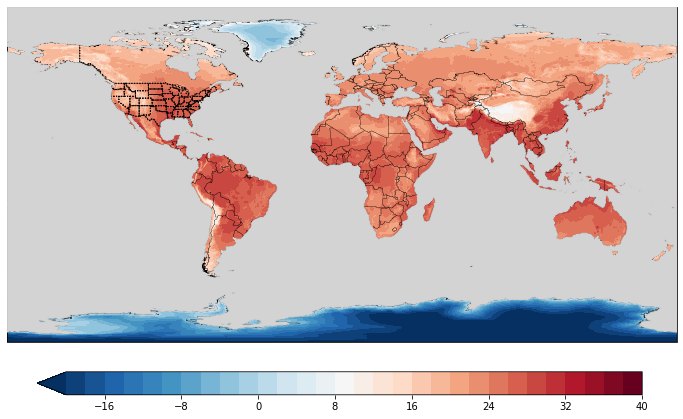

In [10]:
cnlevel = np.linspace(-20, 40, num=31)
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')
im=twb_3d.mean(dim='year').plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
axs.add_feature(cfeature.STATES, linestyle=':')

# zoom in
#axs.set_extent([-128, -68, 25.3, 48])

# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
 

###  The linear trend (over 42 years) in the annual maxima of the daily maxima

In [11]:
trend_2d =np.zeros((n_lat, n_lon))

for nlat in range(n_lat):
    for nlon in range(n_lon):
        arr_1d = twb_3d[:, nlat, nlon] #prec_season_liv[nr,:,ns]
        # first degree polynomial. linear regression 
        trend_2d[nlat,nlon] = np.polyfit(range(len(arr_1d)), arr_1d,1)[0]

In [12]:
#### convert numpy array to dataarray
trend_xr = xr.DataArray(trend_2d, coords={'latitude': twb_3d.latitude, 'longitude':twb_3d.longitude}, 
                           dims=["latitude", "longitude"])
# over n_year
trend_xr = trend_xr*n_year

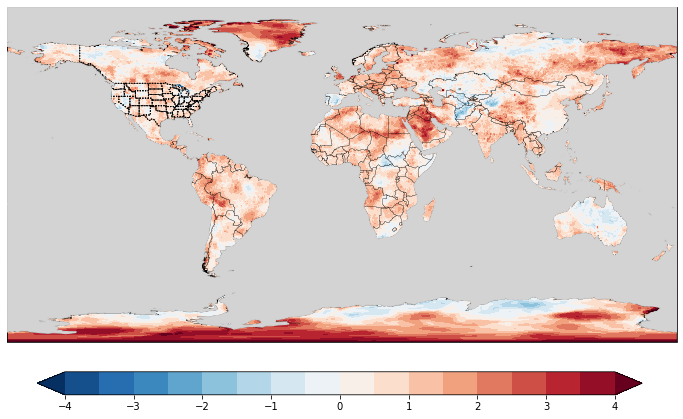

In [14]:
cnlevel = np.linspace(-4, 4, num=17)

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')

im=trend_xr.plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
axs.add_feature(cfeature.STATES, linestyle=':')
 
# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal'); 

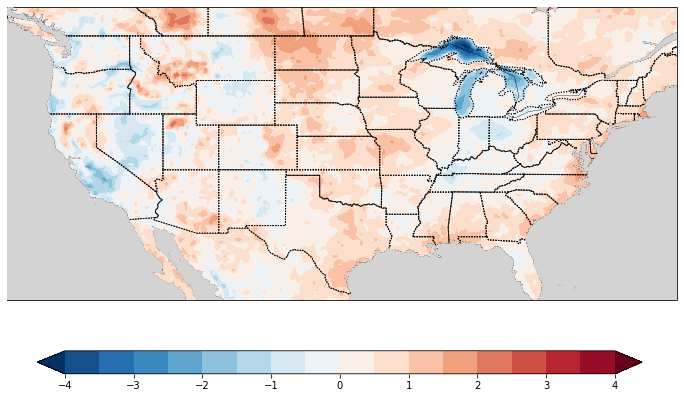

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')

im=trend_xr.plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
axs.add_feature(cfeature.STATES, linestyle=':')

# zoom in
axs.set_extent([-128, -68, 25.3, 48])

# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal'); 

#### P97 of the daily maxima

In [ ]:
a = np.array([1,2,3,4,5,6,7,8,9,10])
p = np.percentile(a, 90) # return 50th percentile, e.g median.
p

In [85]:
 
flnm_o = dir_i + 'TWB_' + str(year_s) + '-' + str(year_e) + '_dailyMax.nc' 

is_first = True
if not os.path.exists(flnm_o): 
    # get daily maximum
    for year in range(year_s, year_e + 1):
        print(year)
        for month in range(1, n_month+1, 1):
            flnm_i = dir_i + 'daily_max/TWB_' + str(year) + str(month).zfill(2) + '_dailyMax.nc'
            #print(flnm_i)
            with xr.open_dataset(flnm_i) as ds:
                twb = ds['TWB']
            if is_first == True:
                twb_0 = twb
                is_first = False
            else:
                twb_3d = xr.concat([twb_0, twb], "dayofyear")
                twb_0 = twb_3d
    print(twb_3d.shape)        
    twb_3d.to_netcdf(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        twb_3d = ds['TWB']


1979
1980
(731, 721, 1440)


In [13]:
flnm_o = dir_i + 'TWB_' + str(year_s) + '-' + str(year_e) + '_dailyMax_p97.nc' 

if not os.path.exists(flnm_o): 
    p97_2d =np.zeros((n_lat, n_lon))

    for nlat in range(n_lat):
        for nlon in range(n_lon):
            arr_1d = 3d[:, nlat, nlon] #prec_season_liv[nr,:,ns]
            # first degree polynomial. linear regression 
            p97_2d[nlat,nlon] = np.percentile(arr_1d, 97)
            p97_2d.to_netcdf(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        p97_2d = ds['TWB']


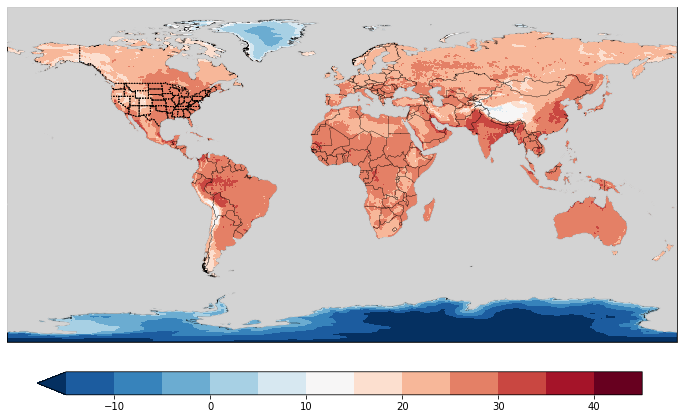

In [23]:
#### convert numpy array to dataarray
p97_xr = xr.DataArray(p97_2d, coords={'latitude': twb_3d.latitude, 'longitude':twb_3d.longitude}, 
                           dims=["latitude", "longitude"])

cnlevel = np.linspace(-15, 45, num=13)

fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')

im = p97_xr.plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
axs.add_feature(cfeature.STATES, linestyle=':')
 
# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal'); 

#### Duration of hot days
 the longest duration (in units of days) where daily maxima > P97 of daily maxima.

In [77]:
durhot_2d =np.zeros((n_lat, n_lon))

for nlat in range(n_lat):
    for nlon in range(n_lon):
        durhot_2d[nlat,nlon] = longestConsecutive(twb_3d[:, nlat, nlon], p97_2d[nlat, nlon]) 

42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa
42 aaaaaa


KeyboardInterrupt: 

In [ ]:
durhot_2d.plot()

In [ ]:
print('aa')


In [ ]:
def longestConsecutive(arr, t0):
    '''
    arr:1d numpy array
    t0: threshold 
    find the longest sequece of arr>t0
          duration of hot days
    '''
      len_a = len(arr)
      longest = 0
      for n in range(len_a):
         #print(arr[n-1],arr[n]) 
         if arr[n-1] < 99 and arr[n]>5:   
            current = i
            streak = 0
            while arr[n] > 99:   
               n+=1
               streak+=1
               longest = max(longest,streak)
      return longest

print(longestConsecutive(np.array([100,6,250,101,8,2])))

#### Hot Nights
 - Calculate a timeseries of daily minima over 40 years
 - Map plot the average (over 40 years) of the annual maximum of the daily minima
 - Map plot the linear trend (over 40 years) in the annual maxima of the daily minima
 - Map plot of P97 of the daily minima.

In [16]:
dir_i = '/glade/campaign/mmm/c3we/mingge/wetbulb/daily_min/'
flnm_o = dir_i + 'TWB_' + str(year_s) + '-' + str(year_e) + '_annual_min.nc' 

if not os.path.exists(flnm_o): 
    # get daily maximum
    for year in range(year_s, year_e + 1):
        for month in range(1, n_month+1, 1):
            flnm_i = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_dailyMin.nc'
            print(flnm_i)
            with xr.open_dataset(flnm_i) as ds:
                twb = ds['TWB'].max(dim='dayofyear')
            if month == 1:
                twb_0 = twb 
            else:
                twb_3d = xr.concat([twb_0, twb], "month")
                twb_0 = twb_3d
            
        twb_max = twb_3d.max(dim='month') 
        if year == year_s:
            twb_1 = twb_max
        else:
            twb_3d = xr.concat([twb_1, twb_max], "year")
            twb_1 = twb_3d
     
    twb_3d.to_netcdf(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        twb_3d = ds['TWB']


/glade/campaign/mmm/c3we/mingge/wetbulb/daily_min/TWB_197901_dailyMin.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/glade/campaign/mmm/c3we/mingge/wetbulb/daily_min/TWB_197901_dailyMin.nc'

#### 1 monthly average wetbulb temperature

In [4]:
dir_i = '/glade/campaign/mmm/c3we/mingge/wetbulb/'
dir_o = dir_i + 'PLOT/'

year_s = 1979
year_e = 2020
#year_e = year_s + 1

n_year = year_e - year_s + 1
n_month = 12

n_lat = 721 
n_lon = 1440

# Create an empty Numpy array  

twb_3d = np.zeros((n_month, n_lat, n_lon))
#twb_3d = np.empty((0, n_lat, n_lon), float)

# calculate monthly average
for month in range(1, n_month+1, 1):
    for year in range(year_s, year_e + 1):
        flnm = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_mean.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            twb = ds['TWB'] 
         
        twb_3d[month-1] = twb_3d[month-1] + twb

twb_3d=twb_3d/n_year

#### Global maps of monthly averages  

In [18]:
#### convert numpy array to dataarray
data_xr = xr.DataArray(twb_3d, coords={'month': range(1,13,1),'latitude': twb.latitude, 'longitude':twb.longitude}, dims=["month","latitude", "longitude"])


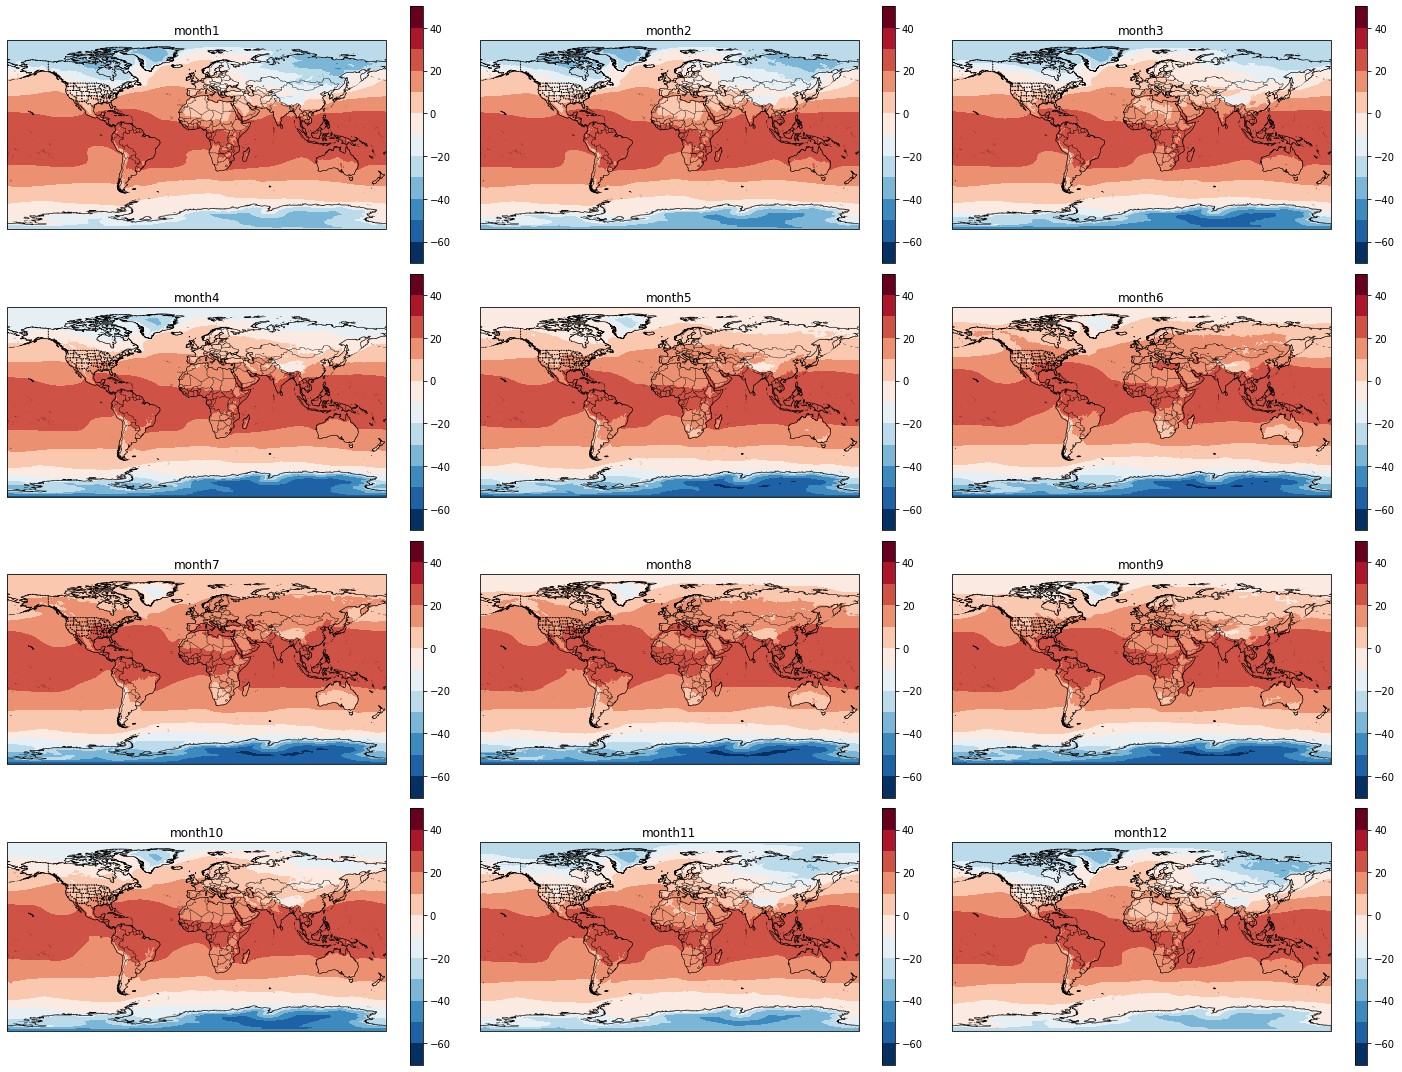

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

cnlevel = np.linspace(-70, 50, num=13)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=data_xr[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month' + str(nn+1))
plt.tight_layout()


##### mask ocean

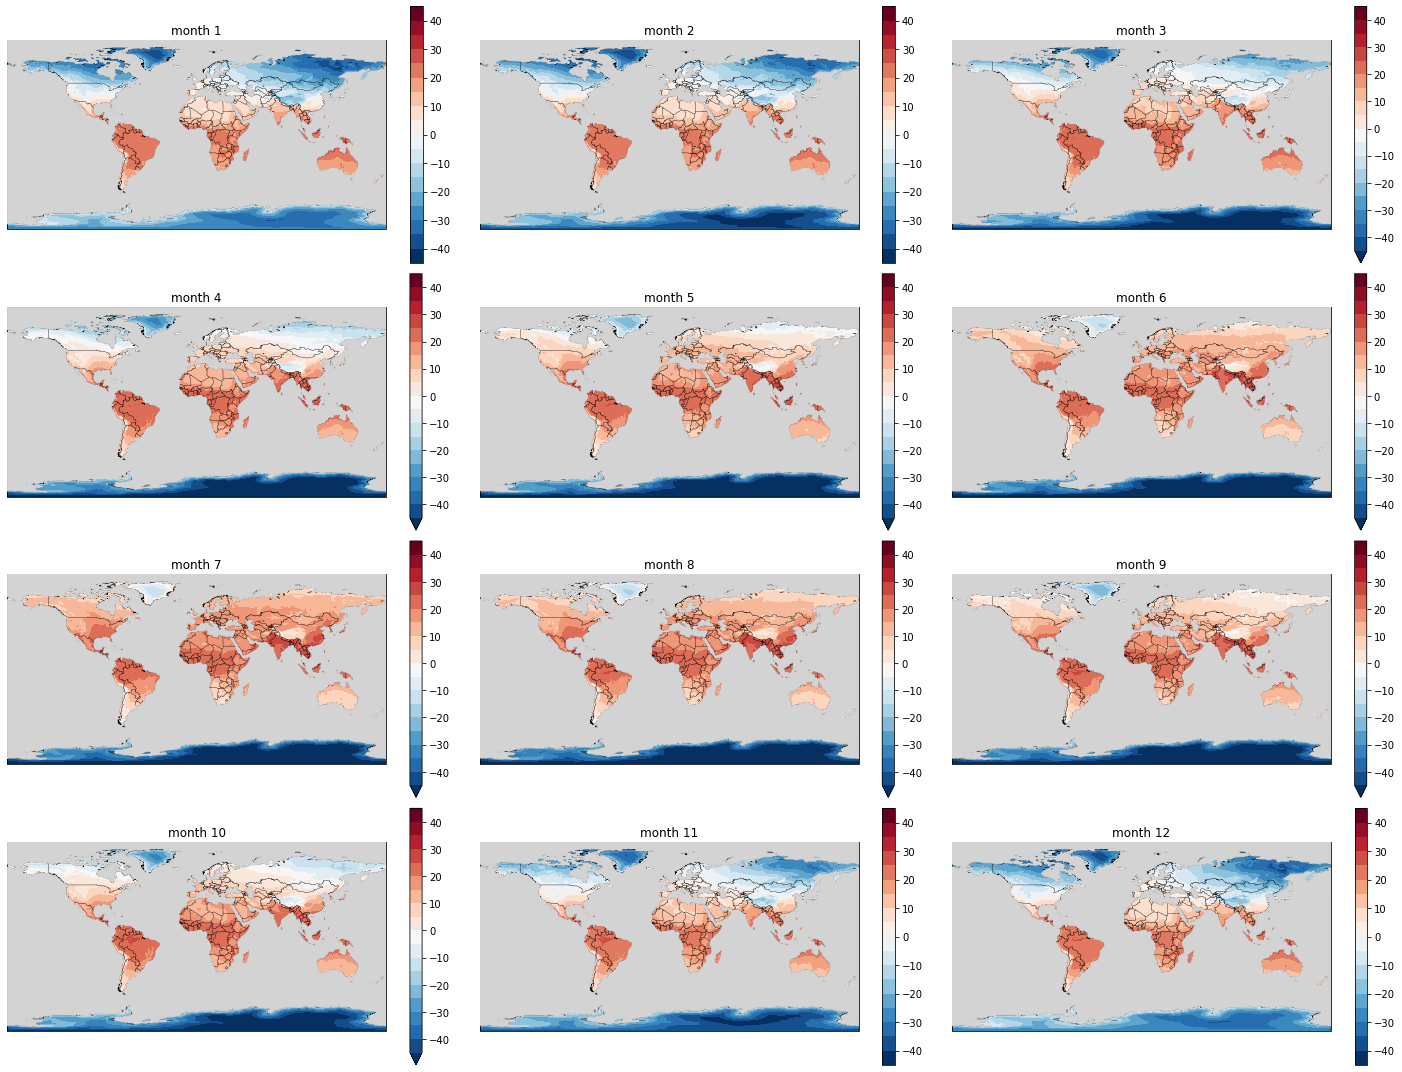

In [22]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

#data_xr = data_xr.where(data_xr < 20, 0)

cnlevel = np.linspace(-45, 45, num=19)
#cnlevel = range(20, 50, 5)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        #axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=data_xr[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month ' + str(nn+1))
        axs[row][col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
plt.tight_layout()

##### set everything <10C to be missing.

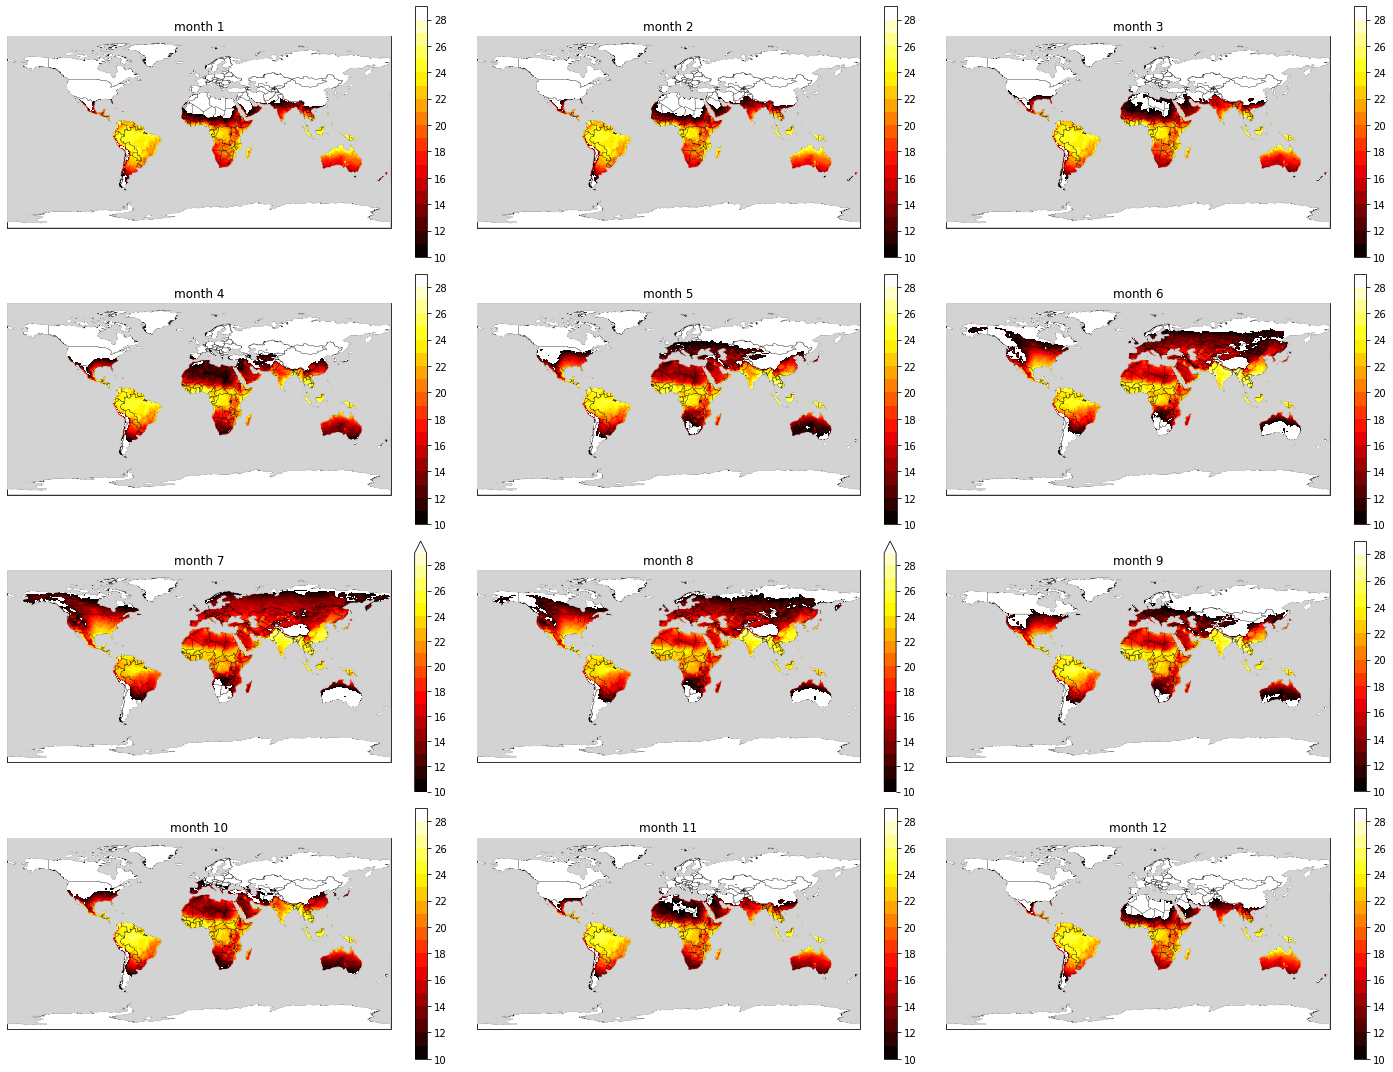

In [40]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

data_xr_new = xr.where(data_xr < 10, np.nan, data_xr)

cnlevel = range(10, 30, 1)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        #axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=data_xr_new[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                cmap='hot',
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month ' + str(nn+1))
        axs[row][col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
plt.tight_layout()

#### 2  Annual average maximum value

In [49]:
dayofmon = [31,28,31,30,31,30,31,31,30,31,30,31]
twb_year = np.zeros((n_year, n_lat, n_lon))
for year in range(year_s, year_e + 1, 1):
    for month in range(1, n_month+1, 1):
        flnm = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_mean.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            twb = ds['TWB'] 
         
        twb_year[year-year_s] = twb_year[year-year_s] + twb*dayofmon[month-1]/365.


In [50]:
#### convert numpy array to dataarray
twb_year_xr = xr.DataArray(twb_year, coords={'year': range(year_s,year_e + 1,1),'latitude': twb.latitude, 'longitude':twb.longitude}, 
                           dims=["year","latitude", "longitude"])

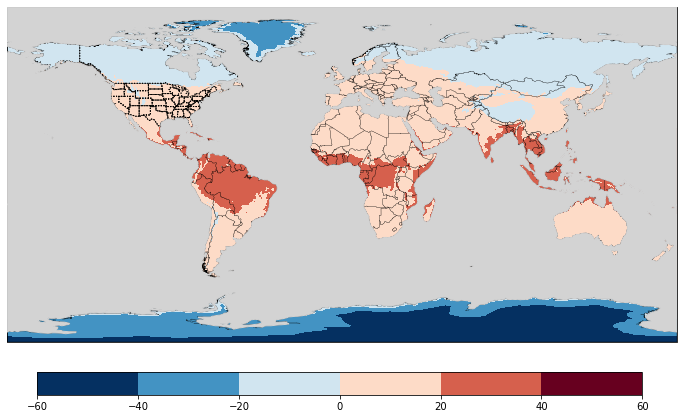

In [58]:
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')
im=twb_year_xr.min(dim='year').plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
axs.add_feature(cfeature.STATES, linestyle=':')

# zoom in
#axs.set_extent([-128, -68, 25.3, 48])

# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal');

##### with ocean

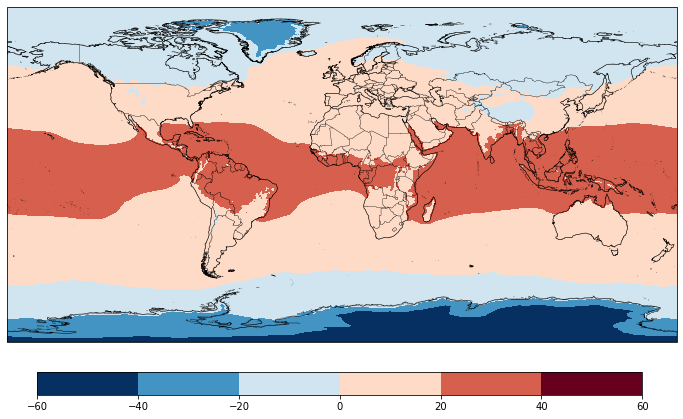

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12,8))
ax_coastlines_country(axs)
#axs.add_feature(cfeature.STATES, linestyle=':')
im=twb_year_xr.min(dim='year').plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=cnlevel,
                ax=axs,
                transform=proj,
                #orientation='horizontal', 
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
#axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

# zoom in
#axs.set_extent([-128, -68, 25.3, 48])

# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.12, 0.7, 0.04])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal');

#### 3 Annual average number of hours > 30C, >32C, and >35C)

In [165]:
n_year = year_e - year_s + 1
ct_arr = np.zeros((n_year, 3, n_lat, n_lon))
for year in range(year_s, year_e + 1, 1):
    for month in range(1, n_month+1, 1):
        flnm = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_head_hr.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            n_3d = ds['__xarray_dataarray_variable__']
         
        ct_arr[year-year_s] = ct_arr[year-year_s] + n_3d


In [166]:
ct_arr_avg = np.mean(ct_arr, axis=0)
ct_arr_xr = xr.DataArray(ct_arr_avg, coords={'threshold': range(1,4,1),'latitude': twb.latitude, 'longitude':twb.longitude}, dims=["threshold","latitude", "longitude"])

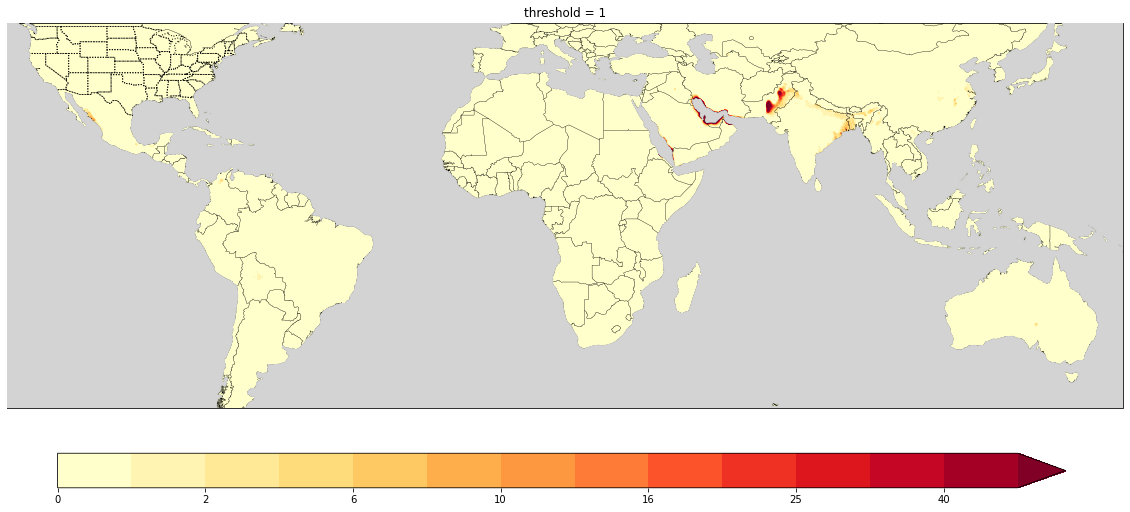

In [167]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,15), subplot_kw={'projection': ccrs.PlateCarree()})

level_s = np.array([0, 1, 2, 4, 6, 8,10, 12,16, 20, 25, 30, 40,50])
ax_coastlines_country(axs) 
axs.add_feature(cfeature.STATES, linestyle=':')
# zoom in
axs.set_extent([-130, 160, -50., 50.], crs=ccrs.PlateCarree())
im=ct_arr_xr[0].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s,
                ax=axs,
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')


# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.25, 0.7, 0.032])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal');

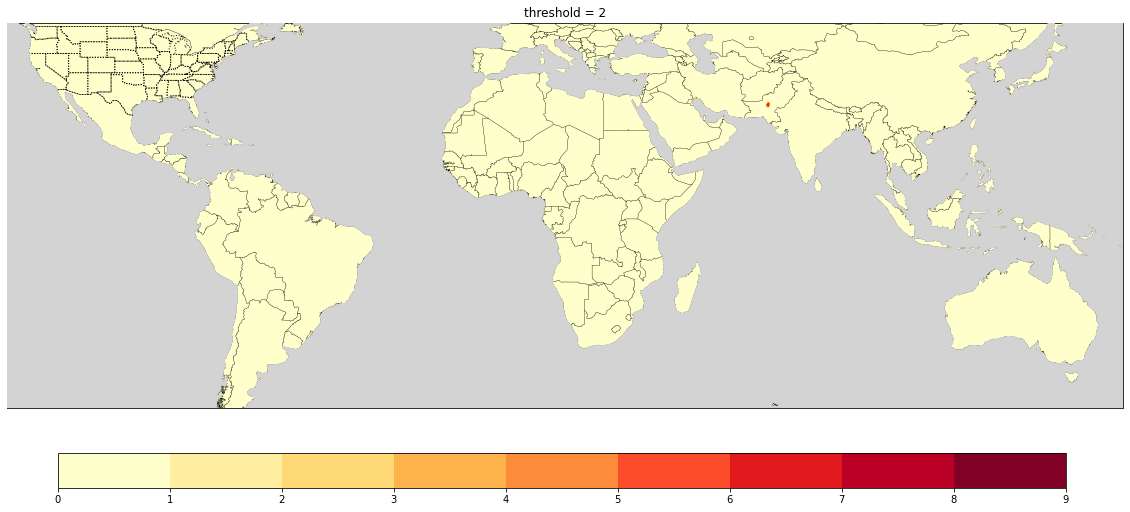

In [168]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,15), subplot_kw={'projection': ccrs.PlateCarree()})

level_s = range(10)
ax_coastlines_country(axs)
axs.add_feature(cfeature.STATES, linestyle=':')
# zoom in
axs.set_extent([-130, 160, -50., 50.], crs=ccrs.PlateCarree())
im=ct_arr_xr[1].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s,
                ax=axs,
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

# zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
axs.add_feature(cfeature.OCEAN, zorder=10,color='lightgray')


# The position of the bottom edge of the subplots, as a fraction of the figure height.
cbar_ax = fig.add_axes([0.16, 0.25, 0.7, 0.032])        
fig.colorbar(im, cax=cbar_ax,orientation='horizontal');

<xarray.DataArray ()>
array(432.02380952)
Coordinates:
    threshold  int64 1
<xarray.DataArray ()>
array(7.5)
Coordinates:
    threshold  int64 2


/glade/scratch/mingge/ipykernel_170169/3260651174.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


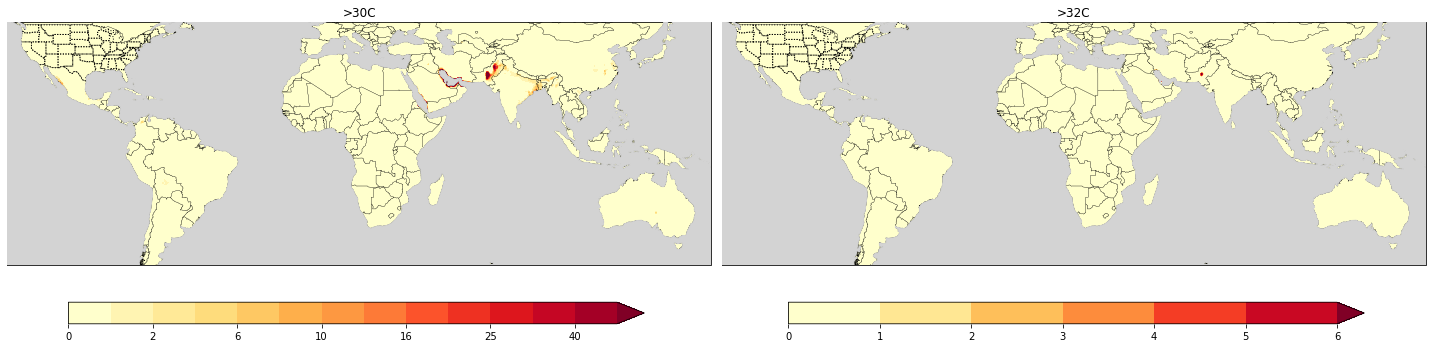

In [169]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
#level_s = [np.array([0, 2, 5, 10, 15, 20, 50, 100, 120, 150, 200]),range(7)]
level_s = [np.array([0, 1, 2, 4, 6, 8,10, 12,16, 20, 25, 30, 40,50]), range(7)]
title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([-130, 160, -50., 50.], crs=ccrs.PlateCarree())
        print(ct_arr_xr[col].max())
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.25, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.25, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

##### zoom in

/glade/scratch/mingge/ipykernel_170169/352886012.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


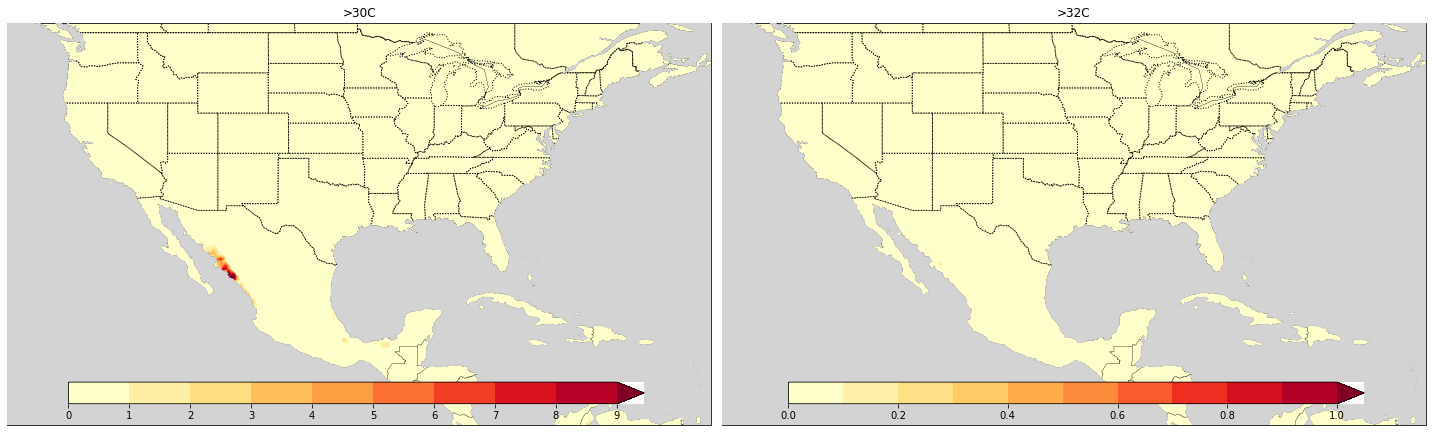

In [170]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
 
level_s = [range(10), np.linspace(0, 1, num=11),]

title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([-130, -60, 10., 50.], crs=ccrs.PlateCarree())
        
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.25, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.25, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

/glade/scratch/mingge/ipykernel_170169/2347419142.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


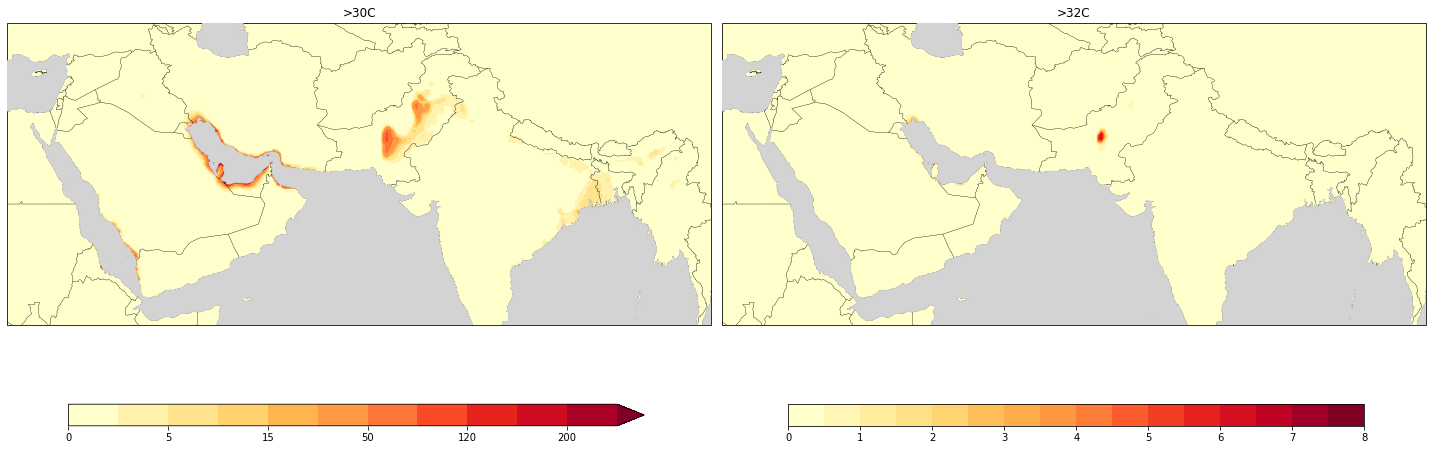

In [171]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
 
level_s = [np.array([0, 2, 5, 10, 15, 20, 50, 100, 120, 150, 200,400]), np.linspace(0, 8, num=17),]

title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([30, 100, 10., 40.], crs=ccrs.PlateCarree())
        
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.15, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.15, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

#### - annual maximum number of hours > 30C, >32C 

In [172]:
ct_arr_max = np.max(ct_arr, axis=0)
ct_arr_xr = xr.DataArray(ct_arr_max, coords={'threshold': range(1,4,1),'latitude': twb.latitude, 'longitude':twb.longitude}, dims=["threshold","latitude", "longitude"])

<xarray.DataArray ()>
array(1140.)
Coordinates:
    threshold  int64 1
<xarray.DataArray ()>
array(105.)
Coordinates:
    threshold  int64 2


/glade/scratch/mingge/ipykernel_170169/2048209939.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


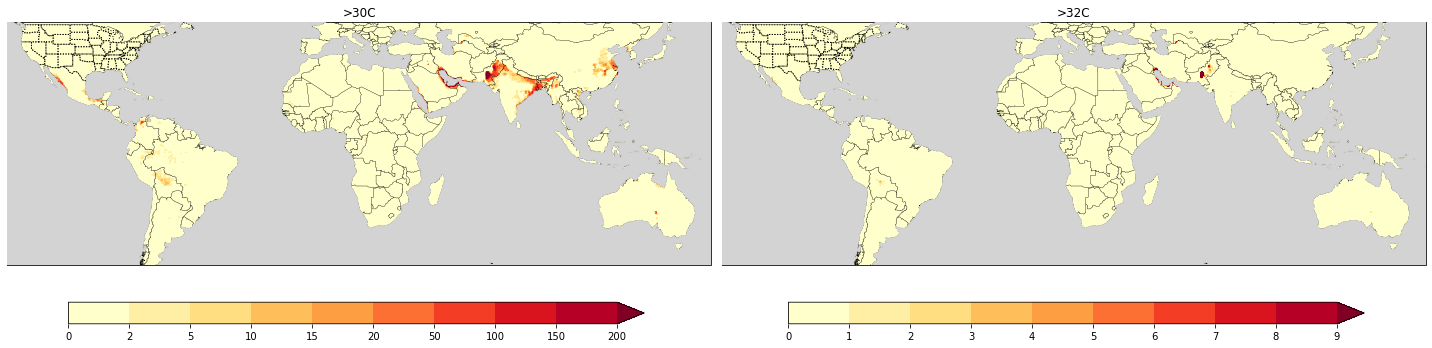

In [173]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
level_s = [np.array([0, 2, 5, 10, 15, 20, 50, 100, 150, 200]),range(10)]
title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([-130, 160, -50., 50.], crs=ccrs.PlateCarree())
        print(ct_arr_xr[col].max())
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.25, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.25, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

/glade/scratch/mingge/ipykernel_170169/2025950239.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


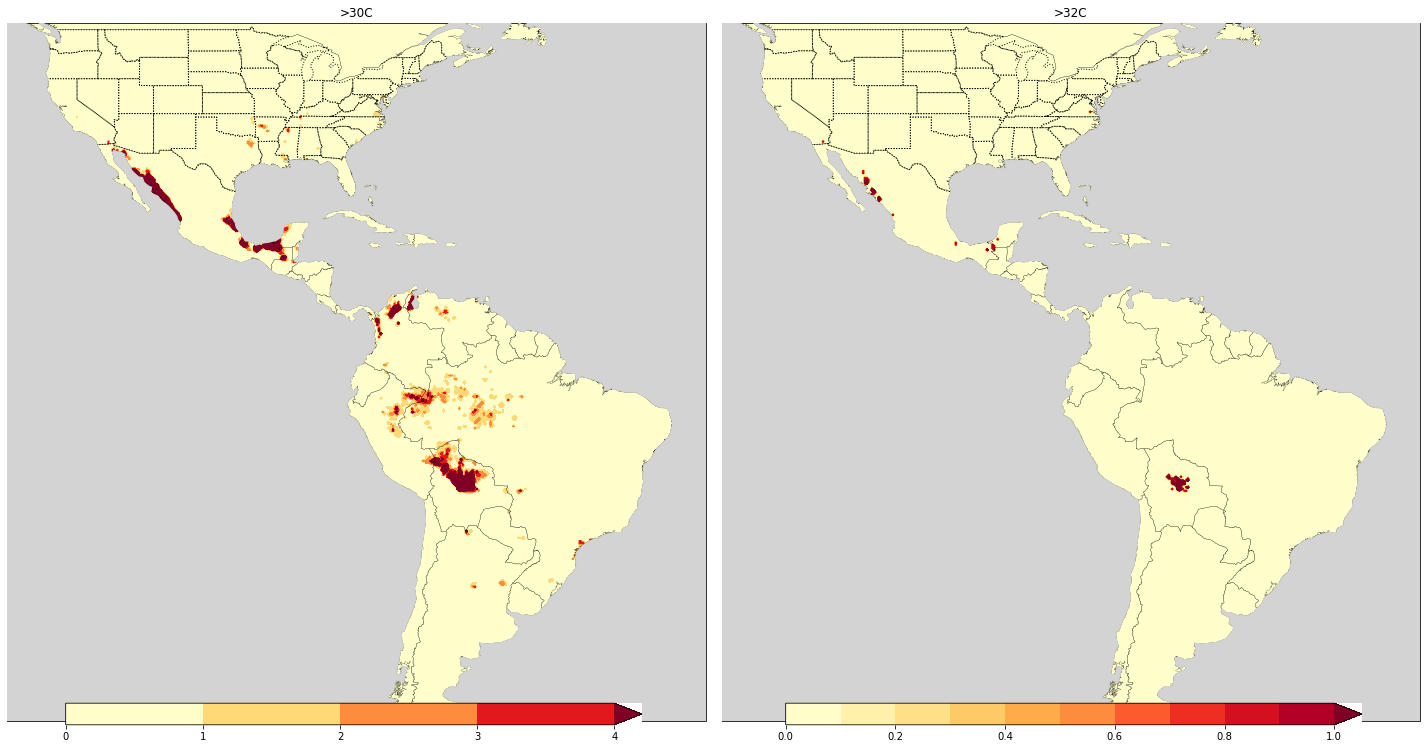

In [187]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
#level_s = [np.array([0, 2, 5, 10, 15, 20, 50, 100, 150, 200]),range(10)]
level_s = [range(5), np.linspace(0, 1, num=11)]
title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([-130, -30, -50., 50.], crs=ccrs.PlateCarree())
         
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.01, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.01, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

/glade/scratch/mingge/ipykernel_170169/4095164451.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


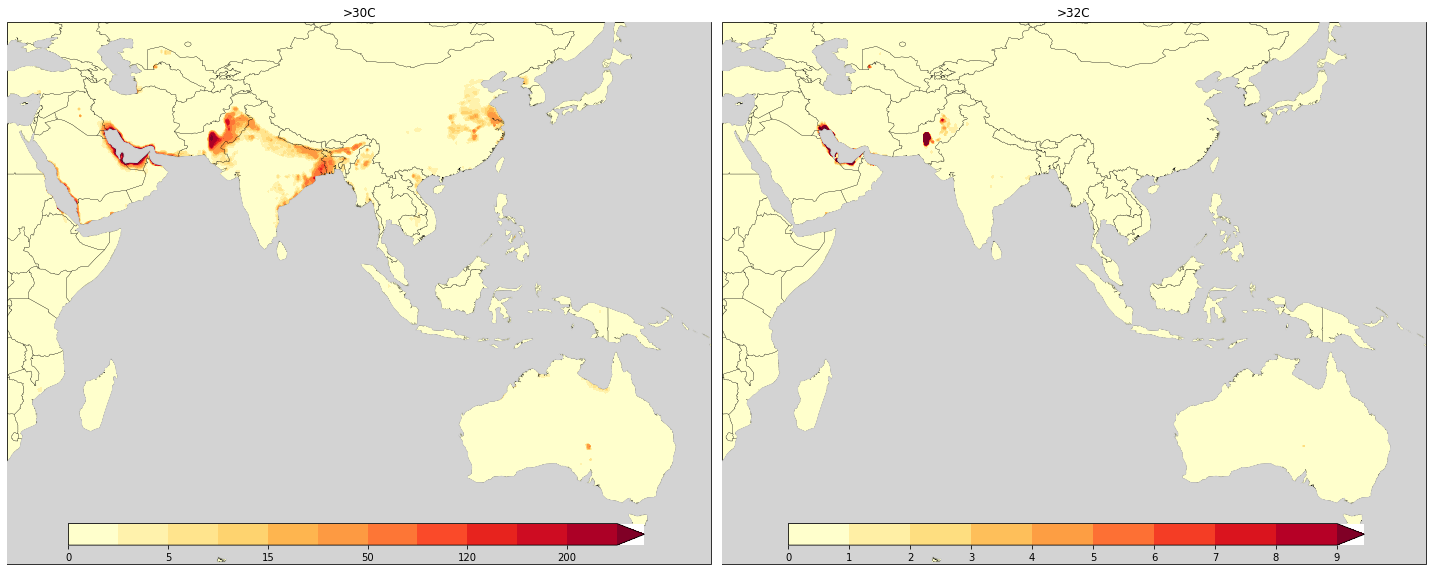

In [193]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,10))
 
level_s = [np.array([0, 2, 5, 10, 15, 20, 50, 100, 120, 150, 200,400]), range(10),]

title_s = ['>30C','>32C']
for col in range(2):
        ax_coastlines_country(axs[col])
        axs[col].add_feature(cfeature.STATES, linestyle=':')
        axs[col].set_extent([30, 160, -50., 50.], crs=ccrs.PlateCarree())
        
        im = ct_arr_xr[col].plot.contourf(
                # reset colorbar label using char_kwargs
                #cbar_kwargs={'label': ""},
                #levels=np.linspace(0, 24, num=11),
                levels=level_s[col],
                ax=axs[col],
                cmap='YlOrRd',
                transform=proj,
                add_colorbar=False)

        axs[col].set_title(title_s[col])
        
        # zorder: parameter to specify the drawing order. Lower zorders will be drawn first  
        axs[col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')

        # The position of the bottom edge of the subplots, as a fraction of the figure height.
        if col == 0 :
            cbar_ax = fig.add_axes([0.05, 0.15, 0.4, 0.03]) 
        else:
            cbar_ax = fig.add_axes([0.55, 0.15, 0.4, 0.03]) 
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal');
plt.tight_layout()

#### 4) Global map of 42-year linear trend by month (C over 42 years)

In [42]:
twb_4d = np.zeros((n_year, n_month, n_lat, n_lon))

# read data
for month in range(1, n_month+1, 1):
    for year in range(year_s, year_e + 1):
        flnm = dir_i + 'TWB_' + str(year) + str(month).zfill(2) + '_mean.nc'
        #print(flnm)
        with  xr.open_dataset(flnm) as ds:
            twb_4d[year-year_s, month-1,:,:] = ds['TWB'] 


In [63]:
# calculate trend by month
trend_3d =np.zeros((n_month, n_lat, n_lon))
for month in range(1, n_month+1, 1): 
    #print(month)
    for nlat in range(n_lat):
        for nlon in range(n_lon):
            arr_1d = twb_4d[:, month-1, nlat, nlon] #prec_season_liv[nr,:,ns]
            # first degree polynomial. linear regression 
            trend_3d[month-1,nlat,nlon] = np.polyfit(range(len(arr_1d)), arr_1d,1)[0] 
 

In [51]:
#### convert numpy array to dataarray
trend_xr = xr.DataArray(trend_3d, coords={'month': range(1, 13,1),'latitude': twb.latitude, 'longitude':twb.longitude}, 
                           dims=["month","latitude", "longitude"])
# over n_year
trend_xr = trend_xr*n_year

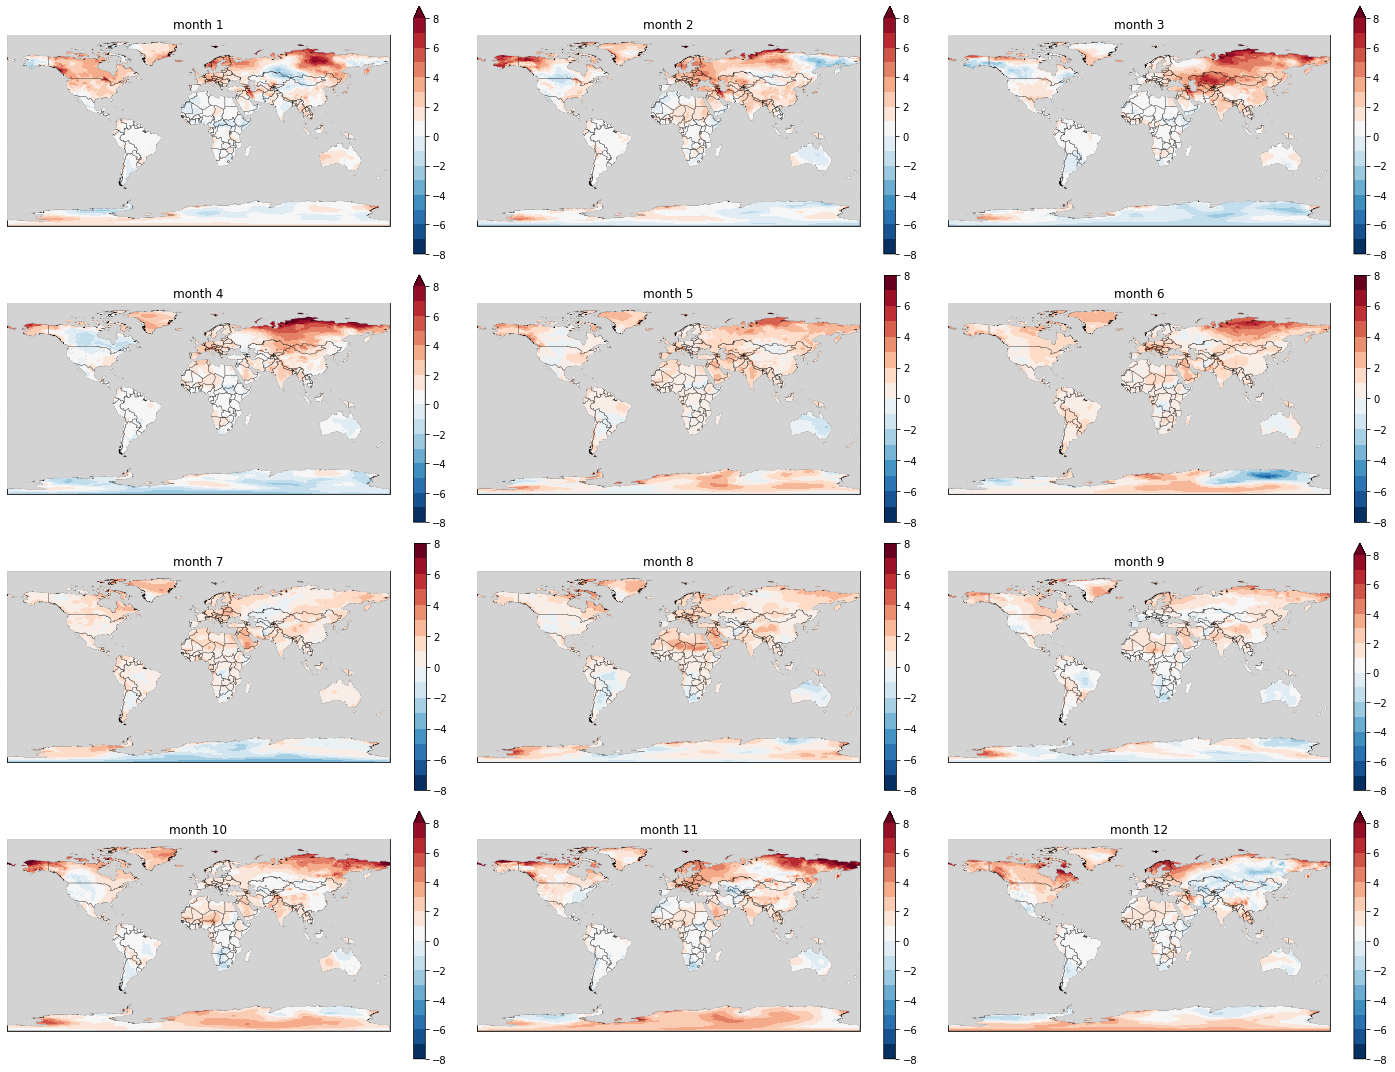

In [62]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

#cnlevel = np.linspace(-45, 45, num=19)
cnlevel = range(-8, 9, 1)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        #axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=trend_xr[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month ' + str(nn+1))
        axs[row][col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
plt.tight_layout()

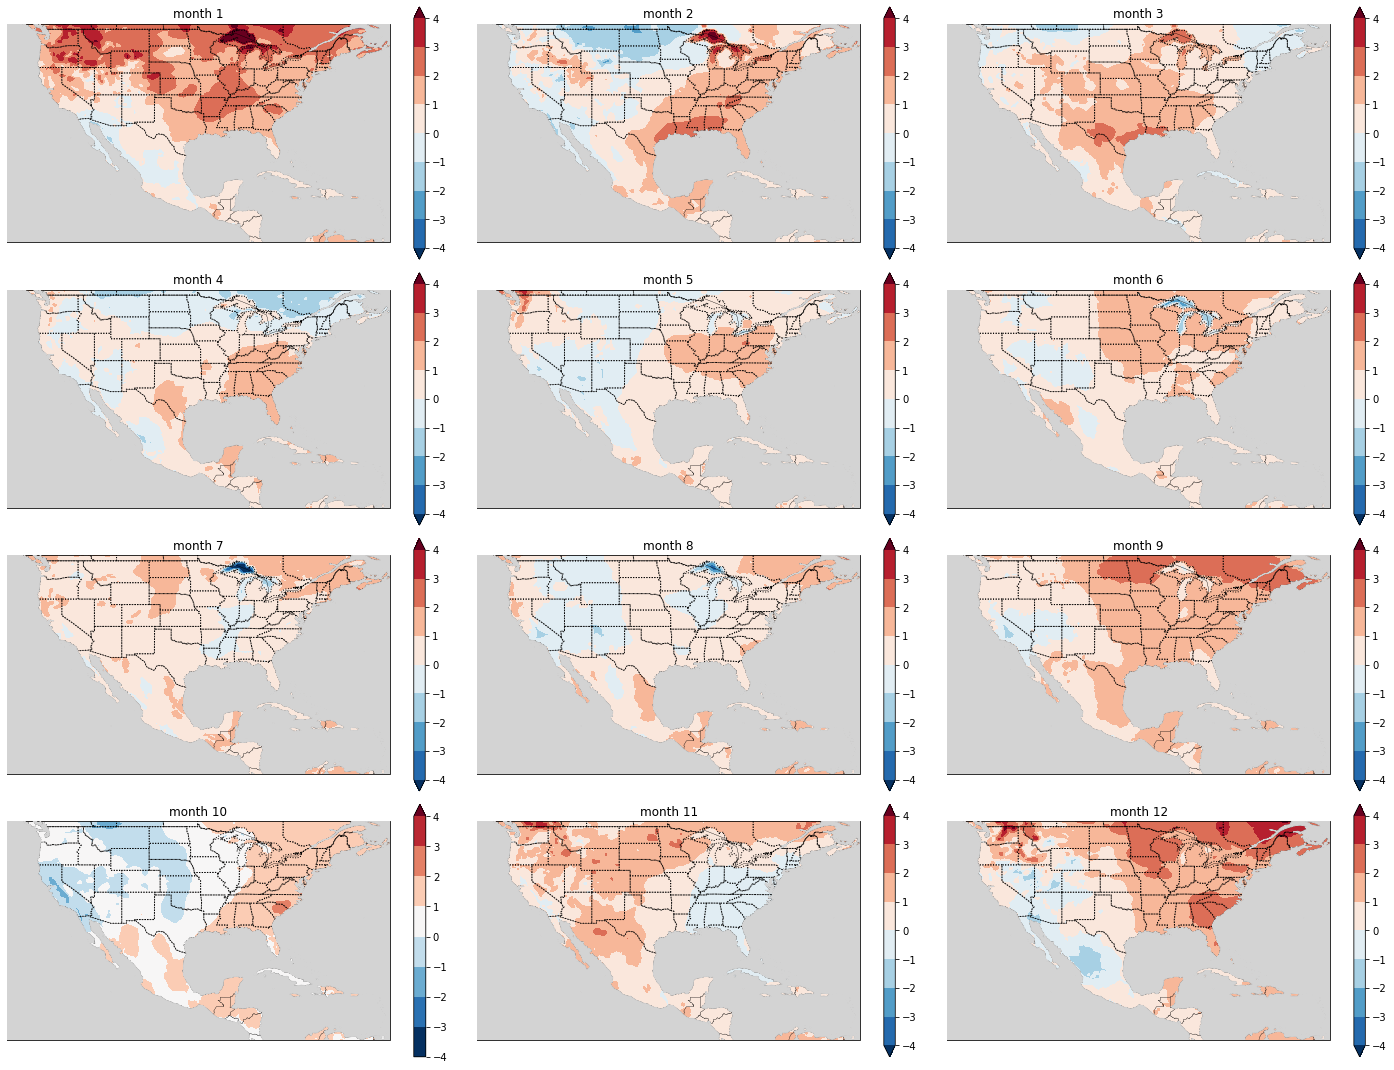

In [61]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

#cnlevel = np.linspace(-45, 45, num=19)
cnlevel = range(-4, 5, 1)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        axs[row][col].set_extent([-130, -60, 10., 50.], crs=ccrs.PlateCarree())
        axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=trend_xr[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month ' + str(nn+1))
        axs[row][col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
plt.tight_layout()

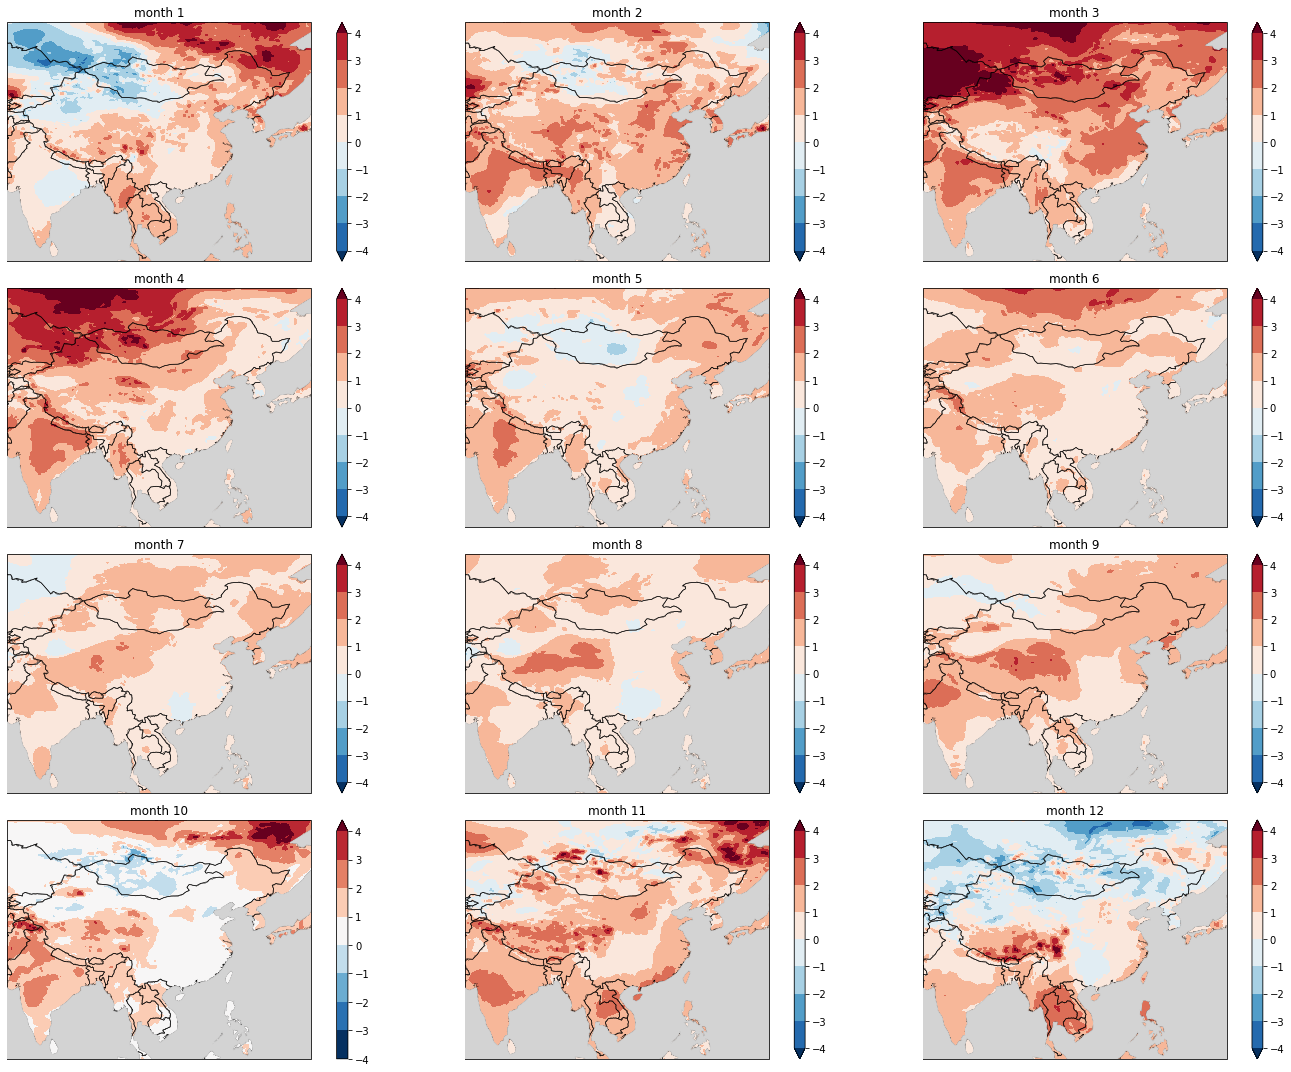

In [68]:
fig, axs = plt.subplots(nrows=4, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(20,15))

cnlevel = range(-4, 5, 1)
for row in range(4):
    for col in range(3):
        nn = col + row*3
        ax_coastlines_country(axs[row,col])
        axs[row][col].add_feature(cfeature.BORDERS, linewidth=0.7)
        axs[row][col].set_extent([70, 140, 5., 60.], crs=ccrs.PlateCarree())
        axs[row,col].add_feature(cfeature.STATES, linestyle=':')
        im=trend_xr[nn].plot.contourf(
                # reset colorbar label using char_kwargs
                cbar_kwargs={'label': ""},
                levels=cnlevel,
                ax=axs[row,col],
                transform=proj,
                add_colorbar=True)
        axs[row][col].set_title('month ' + str(nn+1))
        axs[row][col].add_feature(cfeature.OCEAN, zorder=10,color='lightgray')
plt.tight_layout()
plt.savefig("wetbulb_china.png")